# Import thư viện

In [123]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
import os

# Đọc dữ liệu

In [2]:
df_train = pd.read_csv('train.csv', index_col='date')
df_test = pd.read_csv('test.csv',index_col='date')

# Chia tập validation

In [3]:
df_validate = df_train.iloc[-100:, :]
df_train = df_train.iloc[:-100, :]

In [4]:
df_test.shape

(180, 13)

In [5]:
df_train.shape

(619, 13)

In [6]:
df_validate.shape

(100, 13)

In [7]:
df_train.head()

,is_holiday,temperature,new_total_usage_lag6,new_total_usage_lag7,new_total_usage_lag14,new_total_usage_lag21,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,new_total_usage
date,,,,,,,,,,,,,
2024-03-30,False,28.12,2013.0,2618.0,2178.0,2299.0,False,False,False,False,True,False,2508.0
2023-07-12,False,31.07,6149.0,6369.0,2409.0,7128.0,False,True,False,False,False,False,6347.0
2024-02-14,True,23.25,2156.0,3982.0,4323.0,3784.0,False,True,False,False,False,False,1573.0
2023-02-16,False,22.06,4466.0,4554.0,1276.0,1331.0,False,False,True,False,False,False,3817.0
2022-05-20,False,26.62,2992.0,5841.0,4862.0,5346.0,False,False,False,True,False,False,5368.0


# Chuẩn bị dữ liệu để train

## Drop các cột không dùng

In [8]:
df_train = df_train.drop(['new_total_usage_lag6', 'new_total_usage_lag7', 'new_total_usage_lag14', 'new_total_usage_lag21'], axis='columns')
df_train.head()

,is_holiday,temperature,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,new_total_usage
date,,,,,,,,,
2024-03-30,False,28.12,False,False,False,False,True,False,2508.0
2023-07-12,False,31.07,False,True,False,False,False,False,6347.0
2024-02-14,True,23.25,False,True,False,False,False,False,1573.0
2023-02-16,False,22.06,False,False,True,False,False,False,3817.0
2022-05-20,False,26.62,False,False,False,True,False,False,5368.0


In [9]:
df_validate = df_validate.drop(['new_total_usage_lag6', 'new_total_usage_lag7', 'new_total_usage_lag14', 'new_total_usage_lag21'], axis='columns')
df_validate.head()

,is_holiday,temperature,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,new_total_usage
date,,,,,,,,,
2022-11-13,False,25.60,False,False,False,False,False,True,1364.0
2023-12-24,False,20.10,False,False,False,False,False,True,1309.0
2022-09-30,False,26.78,False,False,False,True,False,False,5951.0
2024-01-18,False,22.22,False,False,True,False,False,False,4345.0
2023-04-28,False,27.29,False,False,False,True,False,False,5038.0


In [10]:
df_test = df_test.drop(['new_total_usage_lag6', 'new_total_usage_lag7', 'new_total_usage_lag14', 'new_total_usage_lag21'], axis='columns')
df_test.head()

,is_holiday,temperature,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,new_total_usage
date,,,,,,,,,
2022-12-20,False,21.46,True,False,False,False,False,False,3454.0
2024-04-12,False,27.57,False,False,False,True,False,False,5654.0
2024-02-05,False,24.71,False,False,False,False,False,False,4499.0
2022-09-23,False,26.05,False,False,False,True,False,False,4917.0
2022-03-02,False,22.61,False,True,False,False,False,False,3597.0


## Chuyển kiểu dữ liệu True/False thành 1/0

In [124]:
def convert_columns_to_int(df, weekday_cols_prefix='weekday_', holiday_col='is_holiday', num_weekdays=6):
    """
    Chuyển đổi các cột 'weekday' và 'is_holiday' của DataFrame sang kiểu dữ liệu int.

    Tham số:
    - df: DataFrame cần chuyển đổi.
    - weekday_cols_prefix: Tiền tố của các cột 'weekday'. Mặc định là 'weekday_'.
    - holiday_col: Tên cột ngày lễ cần chuyển đổi. Mặc định là 'is_holiday'.
    - num_weekdays: Số lượng cột 'weekday' cần chuyển đổi (mặc định là 6).
    
    Trả về:
    - DataFrame với các cột đã được chuyển sang kiểu int.
    """
    
    # Chuyển đổi các cột weekday_{i} thành int
    for i in range(1, num_weekdays + 1):  # Lặp từ 1 tới num_weekdays
        df[f'{weekday_cols_prefix}{i}'] = df[f'{weekday_cols_prefix}{i}'].astype(int)
    
    # Chuyển đổi cột is_holiday thành int
    df[holiday_col] = df[holiday_col].astype(int)
    
    return df

In [125]:
df_train = convert_columns_to_int(df=df_train)
df_validate = convert_columns_to_int(df=df_validate)
df_test = convert_columns_to_int(df=df_test)

## Scale dữ liệu số về 0-1

In [14]:
numerical_cols = ['temperature', 'new_total_usage']
scaler = MinMaxScaler()
df_train[numerical_cols] = scaler.fit_transform(df_train[numerical_cols])
df_test[numerical_cols] = scaler.transform(df_test[numerical_cols])
df_validate[numerical_cols] = scaler.transform(df_validate[numerical_cols])


In [15]:
df_test.head()

,is_holiday,temperature,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,new_total_usage
date,,,,,,,,,
2022-12-20,0,0.199131,1,0,0,0,0,0,0.415254
2024-04-12,0,0.641564,0,0,0,1,0,0,0.697740
2024-02-05,0,0.434468,0,0,0,0,0,0,0.549435
2022-09-23,0,0.531499,0,0,0,1,0,0,0.603107
2022-03-02,0,0.282404,0,1,0,0,0,0,0.433616


In [16]:
n_past = 30

# Tạo tập X, y

Giải thích: mỗi dòng dữ liệu ở tập X sẽ bao gồm n_past dòng dữ liệu ở quá khứ (bao gồm cả 8 features và 1 target value), tập y sẽ là target value ở dòng dữ liệu n_past+1

In [17]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset.iloc[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset.iloc[i,-1])
    return np.array(dataX),np.array(dataY)
trainX,trainY=createXY(df_train,n_past=n_past)
testX,testY=createXY(df_test,n_past=n_past)
validX, validY = createXY(df_validate, n_past=n_past)

In [18]:
len(df_train)

619

In [19]:
len(df_test)

180

In [20]:
trainX.shape

(589, 30, 9)

In [21]:
n_cols = trainX.shape[2]

In [22]:
trainY.shape

(589,)

In [23]:
testX.shape

(150, 30, 9)

In [24]:
testY.shape

(150,)

In [25]:
trainX[0][0]

array([0.        , 0.6813903 , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.29378531])

In [26]:
df_train.iloc[0, :]

is_holiday         0.000000
temperature        0.681390
weekday_1          0.000000
weekday_2          0.000000
weekday_3          0.000000
weekday_4          0.000000
weekday_5          1.000000
weekday_6          0.000000
new_total_usage    0.293785
Name: 2024-03-30, dtype: float64

In [27]:
trainX[0][29]

array([0.        , 0.66545981, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.92231638])

In [28]:
df_train.iloc[29, :]

is_holiday         0.000000
temperature        0.665460
weekday_1          0.000000
weekday_2          0.000000
weekday_3          0.000000
weekday_4          0.000000
weekday_5          0.000000
weekday_6          0.000000
new_total_usage    0.922316
Name: 2023-06-05, dtype: float64

In [29]:
trainY[0]

0.744350282485945

In [30]:
df_train.iloc[30, :]

is_holiday         0.000000
temperature        0.416365
weekday_1          0.000000
weekday_2          1.000000
weekday_3          0.000000
weekday_4          0.000000
weekday_5          0.000000
weekday_6          0.000000
new_total_usage    0.744350
Name: 2022-11-30, dtype: float64

# Train model

In [31]:
# Define the build_model function
def build_model(optimizer='adam'):
    grid_model = Sequential()
    grid_model.add(LSTM(50, return_sequences=True, input_shape=(n_past, n_cols)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss='mse', optimizer=optimizer)
    return grid_model


In [122]:
def plot_stock_prediction(y_pred, validY, scaler, numerical_cols, title='Predict Electricity Consumption'):
    """
    Hàm dự đoán và vẽ biểu đồ cho dữ liệu giá cổ phiếu dựa trên mô hình và scaler.

    Tham số:
    - y_pred: Dự đoán của mô hình, đầu vào cần được reshape
    - validY: Giá trị thực của dữ liệu kiểm tra, đầu vào cần được reshape
    - scaler: Bộ scaler đã được dùng để chuẩn hóa dữ liệu
    - numerical_cols: Số lượng cột dữ liệu (các thuộc tính số cần dự đoán)
    - title: Tiêu đề của biểu đồ (tùy chọn)
    """
    
    # Reshape y_pred và validY để chuẩn bị cho việc đảo ngược chuẩn hóa
    y_pred = y_pred.reshape(-1, 1)
    validY = validY.reshape(-1, 1)
    
    # Tạo các bản sao của y_pred và validY với số cột bằng số lượng thuộc tính số
    y_pred_copies_array = np.repeat(y_pred, len(numerical_cols), axis=-1)
    y_copies_array = np.repeat(validY, len(numerical_cols), axis=-1)
    
    # Inverse transform để đưa dữ liệu về giá trị ban đầu
    y_pred_before_scale = scaler.inverse_transform(y_pred_copies_array)[:, -1]
    y_before_scale = scaler.inverse_transform(y_copies_array)[:, -1]
    
    # Vẽ biểu đồ
    plt.plot(y_before_scale, color='red', label='Real Electricity Consumption')
    plt.plot(y_pred_before_scale, color='blue', label='Predicted Electricity Consumption')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Electricity Consumption')
    plt.legend()
    plt.show()



In [96]:
model = build_model(optimizer='Adadelta')

c:\Users\ASUS\.conda\envs\time_series_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [99]:
save_dir = 'saved_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define the checkpoint callback to save only 5 most recent models
checkpoint = ModelCheckpoint(
    filepath=os.path.join(save_dir, 'model_epoch_{epoch:02d}_loss_{loss:.4f}.keras'), 
    monitor='loss',
    save_best_only=False,  # Save the model every epoch
    mode='auto',
    verbose=1,
    save_weights_only=False  # Save the entire model (architecture + weights)
)


In [104]:
def load_latest_checkpoint(directory):
    model_files = sorted(
        [f for f in os.listdir(directory) if f.endswith('.keras')],
        key=lambda x: os.path.getmtime(os.path.join(directory, x))
    )
    
    if model_files:
        latest_model = model_files[-1]
        print(f"Loading model: {latest_model}")
        return load_model(os.path.join(directory, latest_model))
    else:
        print("No model found, training from scratch.")
        return None

In [110]:
epoch_count = 0
while True:
    print(f"Starting training for epoch set: {epoch_count + 1} to {epoch_count + 10}")
    model = load_latest_checkpoint(save_dir)
    if model is None:
    # Build a new model if no checkpoint is found
        model = build_model(optimizer='Adadelta')
    # Train the model for a set number of epochs (e.g., 10)
    history = model.fit(
        trainX, trainY, 
        batch_size=16, 
        epochs=10, 
        verbose=1, 
        validation_data=(validX, validY),
        callbacks=[checkpoint]
    )

    # Print the loss at the end of each epoch set
    for epoch, loss in enumerate(history.history['loss'], start=1):
        print(f"Epoch {epoch_count + epoch}: Training Loss = {loss}")

    epoch_count += 10

    # Keep only the 5 most recent model files
    model_files = sorted(os.listdir(save_dir), key=lambda x: os.path.getmtime(os.path.join(save_dir, x)))
    if len(model_files) > 5:
        for old_file in model_files[:-5]:
            os.remove(os.path.join(save_dir, old_file))

Starting training for epoch set: 1 to 10
No model found, training from scratch.
Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2098
Epoch 1: saving model to saved_models\model_epoch_01_loss_0.2115.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.2099 - val_loss: 0.2085
Epoch 2/10
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2280
Epoch 2: saving model to saved_models\model_epoch_02_loss_0.2091.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2270 - val_loss: 0.2042
Epoch 3/10
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2050
Epoch 3: saving model to saved_models\model_epoch_03_loss_0.2046.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2049 - val_loss: 0.2000
Epoch 4/10
36/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1916
Epoch 4: saving model to saved_models\model_epoch_04_loss_0.2009.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1921 - val_loss: 0.1957
Epoch 5/10
35/37 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1857
Epoch 5: s

KeyboardInterrupt: 

In [112]:
model_latest = load_latest_checkpoint(save_dir)

Loading model: model_epoch_06_loss_0.0666.keras


In [113]:
y_pred_latest = model_latest.predict(validX)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


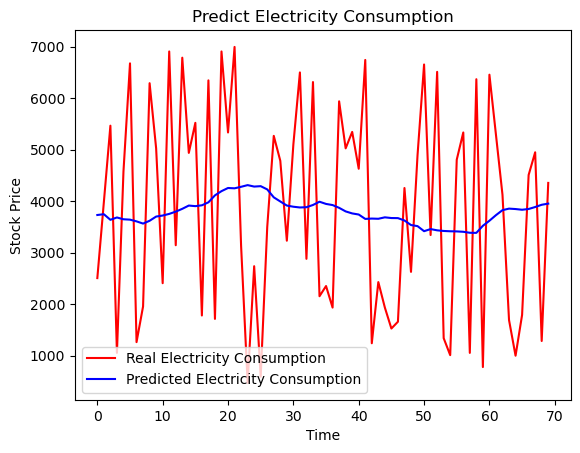

In [121]:
plot_stock_prediction(y_pred=y_pred_latest, validY=validY, scaler=scaler, numerical_cols=numerical_cols)